<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Design" data-toc-modified-id="Design-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Design</a></span><ul class="toc-item"><li><span><a href="#Examples-of-sequence-functions" data-toc-modified-id="Examples-of-sequence-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Examples of sequence functions</a></span></li></ul></li></ul></div>

In [ ]:

# frequently used builtins
import os
from collections import Counter, defaultdict

# frequently used data pkgs
import numpy as np
import pandas as pd
			
# careful import of matplotlib
try:
	import matplotlib.pyplot as plt
except ModuleNotFoundError as e:  # to catch ModuleNotFoundError: No module named '_tkinter'
	import matplotlib
	matplotlib.use('agg')
	import matplotlib.pyplot as plt

# some magic stuff
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'




# Objective

This package offers tools for generating sequences. Finite ones like lists and arrays, or infinite ones like streams. 

The items of the sequences can be anything and often one sequence produced will be used to produce another (see further design notes). 
The target (i.e. final) sequence items would be samples of a signal (like sound, image, or other data from some sensor source) or typical time-series. 

For starters, our main focus will be generating sound -- that is, servicing the [hum](https://github.com/otosense/hum) package. 

Our main tools will be taken from [creek](https://github.com/i2mint/creek) and possibly [lined]()


# Design

Our running examples will be taken from audio production. 
We'll use `wf` to denote a waveform object (usually a list or array of numbers -- a.k.a. samples or frames). 

To get a waveform, you specify some `params` (including, say, the kind, 
or the actual function that the params should be called with to produce the result), 
and you get a waveform `wf`.

![image](https://user-images.githubusercontent.com/1906276/129167933-b1cdba31-0e8c-46b9-b789-c89732d06ce3.png)

This `wf` could be a fixed-size object like an array, or could be a source of unbounded amounts of data, 
like a generator, a stream object, a or a `creek.InfiniteSeq` which gives you the array-like ability to slice (i.e. `wf[i:j]`). 

The purpose of `slink` is to provide tools to get from params to this `wf`, or what ever the target sequence maybe. 
The main means of doing so is through a chain of sequences each one being a function of the previous. 
This function could do things like...


<img src="https://user-images.githubusercontent.com/1906276/129180811-c6f94159-8a9b-4f42-9f99-34607ade643d.png" alt="drawing" style="width:1000px"/>


```python
a, b, c... -> wf_for(a), wf_for(b), wf_for(c), ...  # generate elements of the next sequence based on the items of the last
wf_a, wf_b, wf_c... -> add_noise(wf_a), add_noise(wf_b), add_noise(wf_c), ... # transform the items of the last sequence
-> concatinate(wf_a_with_noise, ...)  # aggregate these items
-> chunk -> wf_chk_1, wf_chk_2, ...  # split these items
```

All but the last sequence functions above were all 
- `map` (applying the same function to each element of the input sequence) 
- `reduce` (aggregating all sequence items into one object -- though that object may be a sequence itself)

But some functions can have more complex mechanisms such as inner-state and buffers. 
This is important to note, since the developer may be tempted to accomodate for sequence functions that operate on a window instead of a single item. 
But accomodating for this directly would complexify the interface.
Instead, we propose to use a mechanism like `lined.BufferStats` to offer a window-input functionality with a single-item-at-a-time interface.

## Examples of sequence functions

For categoricals: Use the `__getitem__` of a mapping that relates each element of a finite set of seeds to a waveform, 
or parameters that will be used to produce the waveform:

```python
cat_map = {'a': [1,2,3], 'b': [4,5,6]}
item_func_1 = cat_map.__getitem__
# to make the sequence function from this item func, you can do:
from lined import iterize
seq_func_1 = iterize(item_func_1)
```

Could also use finite mappings like above for numericals by first using a function that will map to a categorical

```python
num_to_cat = lambda num: list(cat_map)[num % len(cat_map)]
from lined import iterize, Line
seq_func_2 = iterize(Line(num_to_cat, item_func_1))
```

`Line` composes `num_to_cat` and `item_func_1` and `iterize` makes the item-to-item function into a sequence-to-sequence function.



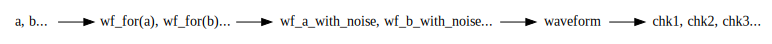

In [14]:
from ut import dgdisp

dgdisp("""
rankdir=LR
categories -> wfs_for_each_category -> transformed_wf_for_each_category -> concatinate -> chunk
categories [label="a, b..." shape=none]
wfs_for_each_category [label="wf_for(a), wf_for(b)..." shape=none]
transformed_wf_for_each_category [label="wf_a_with_noise, wf_b_with_noise..." shape=none]
concatinate [label="waveform" shape=none]
chunk [label="chk1, chk2, chk3..." shape=none]
""")

In [ ]:
a, b, c... -> wf_for(a), wf_for(b), wf_for(c), ...  
wf_a, wf_b, wf_c... -> add_noise(wf_a), add_noise(wf_b), add_noise(wf_c), ... 
-> concatinate(wf_a_with_noise, ...)  

-> chunk -> wf_chk_1, wf_chk_2, 
